In [5]:
import os
import time
import itertools

from torchvision.transforms import v2
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm
from IPython import display
import gc 


%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def data_split(test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds):
    assert 0 <= test_prop <= 1, 0 <= val_prop <= 1
    assert 0 <= fold_idx < nfolds, f'fold_idx was set to {fold_idx} but must be in the range [0, {nfolds - 1} = (nfolds - 1)]'
    batch_data = dsl[dsl['batch_id_x'] == batch_id]
    val_prop = 1 / nfolds
    
    if test_module_ids is not None:
        test_data = batch_data[batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        train_data = batch_data[~batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        assert len(test_data) > 0 and len(train_data) > 0, 'At least one module_id in test_modules={test_module_ids} is invalid.'        
        test_idx = test_data.index.values

        ntrain = len(train_data)
        nval = int(ntrain / nfolds)
        
        # nbdd = int((ntrain - nval) * boundary_prop / 2)
        left_val_idx = int(nval * fold_idx)
        right_val_idx = int(nval * (fold_idx + 1))
        
        val_idx = train_data[left_val_idx: right_val_idx].index.values
        
        train_idx = np.append(
            train_data[:max(0, left_val_idx - nval)].index.values,
            train_data[right_val_idx + nval:].index.values
        )
    else:
        batch_data = batch_data.sort_values(by = 'frame_unix_t')
        test_split = int(len(batch_data) * test_prop)
        ntrain = len(batch_data) - test_split
        val_split = int(ntrain * val_prop)
        boundary_cnt = int((len(batch_data) - val_split) * boundary_prop)
        
        test_idx = batch_data[:test_split].index.values
        val_idx = batch_data[test_split: test_split + val_split].index.values
        train_idx = batch_data[test_split + val_split + boundary_cnt:].index.values
    assert len(set(val_idx).intersection(set(train_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'
    assert len(set(train_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between train_idx and train_idx'
    assert len(set(val_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'

    return test_idx, val_idx, train_idx

def get_windowed_test_val_train_indices(test_prop, boundary_prop=0.2, test_module_ids=None, fold_idx=0, nfolds=5):
    test_indices = np.array([], dtype=np.int64)
    val_indices = np.array([], dtype=np.int64)
    train_indices = np.array([], dtype=np.int64)

    for batch_id in dsl['batch_id_x'].unique():
        test_idx, val_idx, train_idx = data_split(
            test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds
        )
        test_indices = np.concatenate((test_indices, test_idx))
        val_indices = np.concatenate((val_indices, val_idx))
        train_indices = np.concatenate((train_indices, train_idx))
    return test_indices, val_indices, train_indices


def get_shuffled_test_val_train_indices(test_prop, val_prop):
    dataset_size = len(dsl)
    dataset_indices = np.arange(dataset_size)
    
    np.random.shuffle(dataset_indices)
    
    # Test / Train split
    test_split_index = int(np.floor(test_prop * dataset_size))
    trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]
    
    # Train / Val split
    trainset_size = len(trainset_indices)
    val_split_index = int(np.floor(val_prop * trainset_size))
    train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]
    return test_idx, val_idx, train_idx

def preview_frames(data_loader, frame_time=0.01):
    try:
        for X, Y in data_loader:
            for img in X:
                plt.imshow(img.reshape((32,32)), vmin=-2, vmax=2, cmap='icefire')
                plt.show()
                plt.close()
                time.sleep(frame_time)
                display.clear_output(wait=True)
    except KeyboardInterrupt:
        plt.close()
    finally:
        plt.close()
        gc.collect()

def get_dataloader_preview(data_loader, stride, title, frame_time=0.01, ax=None):
    # try:
    stacked = None
    # k = 0
    for X, Y in data_loader:
        curr = X[::stride]
        if len(curr) != batch_size // stride:
            continue
        curr = curr.reshape(32 * batch_size // stride, 32).T
        # plt.imshow(curr, vmin=-2, vmax=2, cmap='icefire')
        # plt.show()
        # plt.close()
        # time.sleep(0.5)
        # display.clear_output(wait=True)
        if stacked is None:
            stacked = curr
        else:
            stacked = np.concatenate((stacked, curr), axis=0)
        # k += 1
        # if k > 3:
            # break
    ax.imshow(stacked, vmin=-2, vmax=2, cmap='icefire')
    ax.set_title(title)
    # except KeyboardInterrupt:
    #     plt.close()
    # finally:
    #     plt.close()
    #     gc.collect()


def get_dataset_preview(dataset, idxs, title, nrows, ncols, ax):
    imgs = np.zeros((nrows * 32, ncols * 32))
    sample_idxs = np.random.choice(idxs, nrows * ncols, replace=False)
    if len(sample_idxs) < nrows * ncols:
        return 'Not enough data'
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        X, Y = dataset[idx]
        curr = X.reshape(32,32)
        imgs[row*32:(row+1)*32, col*32:(col+1)*32] = curr.numpy()
    ax.imshow(imgs, vmin=-2, vmax=2, cmap='icefire')
    ax.set_title(title)


def get_cloudy_stats(data, idx):
    filtered_data = data.iloc[idx]
    clear_data = filtered_data.loc[filtered_data['label'] == 'clear_night_sky']
    cloudy_data = filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy']
    prop_clear = len(clear_data) / len(filtered_data)
    prop_cloudy = len(cloudy_data) / len(filtered_data)
    return len(cloudy_data), prop_cloudy


def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    ncloudy, prop_cloudy = get_cloudy_stats(data, idx)
    unique_module_ids = list(np.sort(filtered_data["module_id"].unique()))
    print(f'Percent cloudy (in {name}) = {100 * prop_cloudy:.3f}% ({ncloudy} / {len(filtered_data)}); '
          f'Unique module_ids: {unique_module_ids}')

def get_fold_class_dists(nfolds):
    df = pd.DataFrame(columns=['Fold_idx', 'dataset', 'ncloudy', 'cloudy_prop', 'size'])
    for fold_idx in range(nfolds):
        # Get data splits
        test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
            test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
        )
        print(f'Fold {fold_idx}')
        for idxs, name in zip([test_idx, val_idx, train_idx], ['test', 'val', 'train']):
            ncloudy, cloudy_prop = get_cloudy_stats(dsl, idxs)
            row = [fold_idx, name, ncloudy, cloudy_prop, len(idxs)]
            df.loc[len(df)] = row
            print('\t', end='')
            print_class_dist(dsl, idxs, name)
    print_class_dist(dsl, dsl.index, 'overall')

In [8]:
# Creating the datasets

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.RandomRotation(90, expand=False),
    v2.Normalize(mean=[0], std=[100]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])

target_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0], std=[100]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float, scale=True),
])


train_labeled_data = CloudDetectionTrain(
    transform=transform
)

test_labeled_data = CloudDetectionTrain(
    target_transform=target_transform
)

dsl = train_labeled_data.dsl_df
dataset_size = len(dsl)

In [9]:
test_prop = 0.3
nfolds = 8
boundary_prop = 0.1 # Proportion of data to discard between the validation and train_proportions (time)
batch_size = 64

In [10]:
test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
    test_prop, boundary_prop, test_module_ids=[3], fold_idx=0, nfolds=nfolds
)

# test_idx, val_idx, train_idx = get_shuffled_test_val_train_indices(test_prop, val_prop)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop (of dataset) = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop (of trainset)= {100 * len(train_idx) / (len(val_idx) + len(train_idx)):.2f}%\n'
      f'val_prop (of trainset) = {100 * len(val_idx) / (len(val_idx) + len(train_idx)):.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]


print_class_dist(dsl, test_idx, 'test')
print_class_dist(dsl, val_idx, 'val')
print_class_dist(dsl, train_idx, 'train')
print_class_dist(dsl, dsl.index, 'overall')
print(len(val_idx) / (len(val_idx) + len(train_idx)))
print(min(val_idx))

test_prop (of dataset) = 33.34%
train_prop (of trainset)= 85.78%
val_prop (of trainset) = 14.22%
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 52.466% (383 / 730); Unique module_ids: [1, 254]
Percent cloudy (in train) = 56.118% (2472 / 4405); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
0.14216163583252192
0


In [11]:
test_df = get_fold_class_dists(nfolds)

Fold 0
	Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
	Percent cloudy (in val) = 52.466% (383 / 730); Unique module_ids: [1, 254]
	Percent cloudy (in train) = 56.118% (2472 / 4405); Unique module_ids: [1, 254]
Fold 1
	Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
	Percent cloudy (in val) = 53.288% (389 / 730); Unique module_ids: [1, 254]
	Percent cloudy (in train) = 55.864% (2053 / 3675); Unique module_ids: [1, 254]
Fold 2
	Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
	Percent cloudy (in val) = 57.397% (419 / 730); Unique module_ids: [1, 254]
	Percent cloudy (in train) = 55.565% (2042 / 3675); Unique module_ids: [1, 254]
Fold 3
	Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
	Percent cloudy (in val) = 53.973% (394 / 730); Unique module_ids: [1, 254]
	Percent cloudy (in train) = 53.388% (1962 / 3675); Unique module_ids: [1, 254]
Fold 4
	Percent cloudy (in test) = 54.533% (1600 / 2

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8


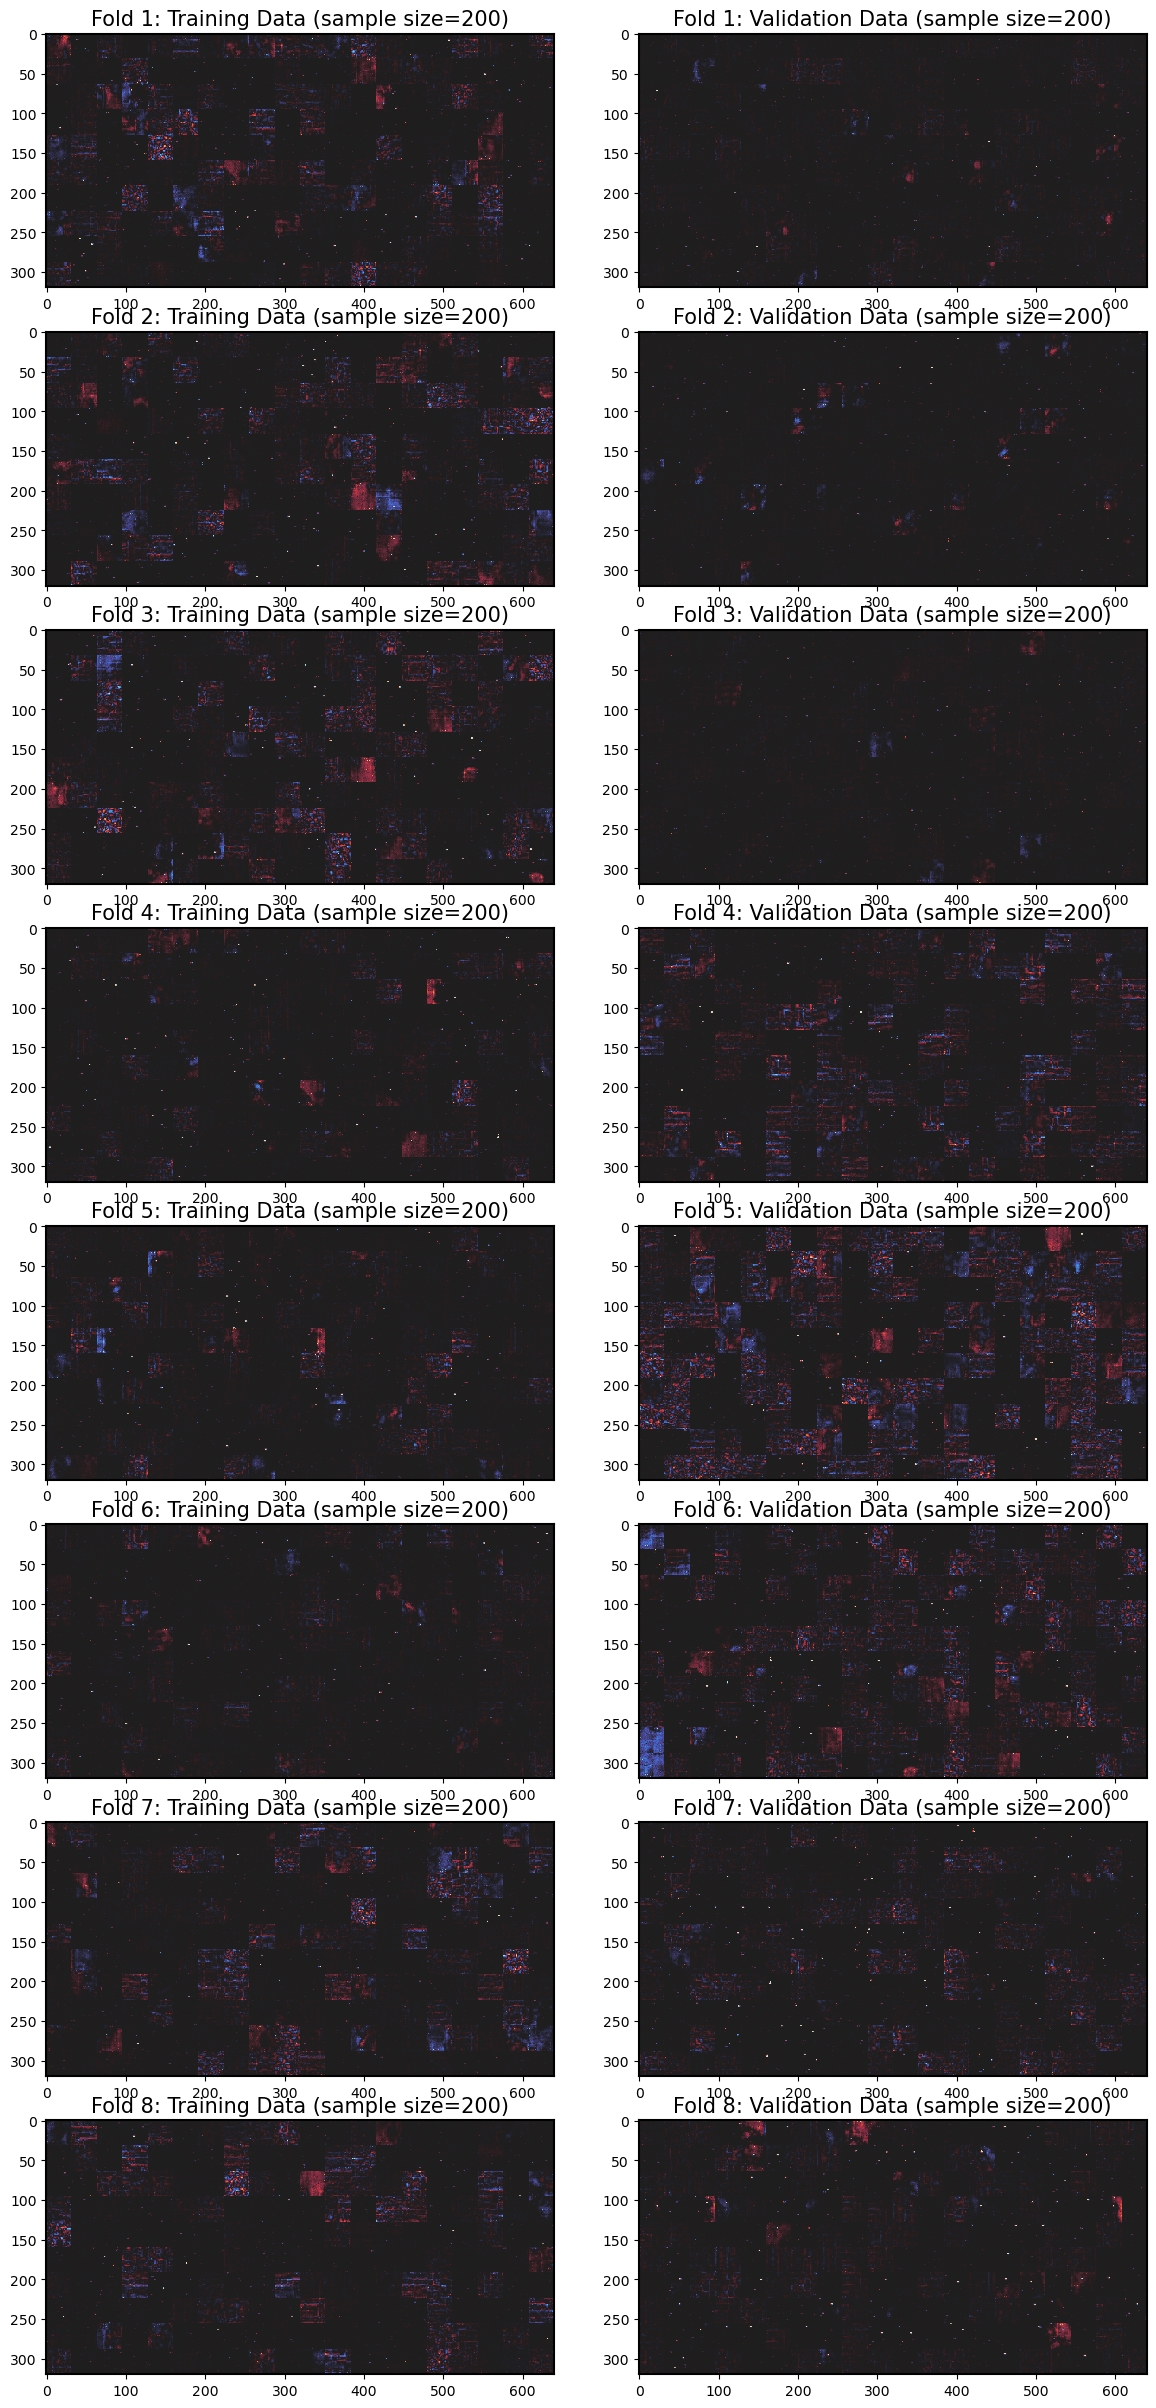

In [13]:
fig, axs = plt.subplots(nfolds, 2, figsize=(12, 24))
fig.tight_layout()
for fold_idx in range(nfolds):
    # Get data splits
    test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
        test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
    )
    print(f'Fold {fold_idx + 1}')
    np.random.shuffle(train_idx)
    np.random.shuffle(val_idx)
    # train_loader = torch.utils.data.DataLoader(
    #           dataset=train_labeled_data,
    #           batch_size=batch_size,
    #           sampler=torch.utils.data.SubsetRandomSampler(train_idx[::5])
    # )  
    # val_loader = torch.utils.data.DataLoader(
    #   dataset=test_labeled_data,
    #   batch_size=batch_size,
    #   sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
    # )
    
    # get_dataset_preview(train_loader, stride=1, title=f'Fold {fold_idx} Training Data Sample', ax=axs[fold_idx][0])
    # get_dataset_preview(val_loader, stride=1, title=f'Fold {fold_idx} Validation Data Sample', ax=axs[fold_idx][1])
    nrows, ncols = 10, 20
    get_dataset_preview(
        train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
        nrows=nrows, ncols=ncols, ax=axs[fold_idx][0]
    )
    get_dataset_preview(
        test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
        nrows=nrows, ncols=ncols, ax=axs[fold_idx][1]
    )
plt.show(fig)
plt.close()

In [19]:
learning_rate = 0.001
weight_decay = 1e-5
epochs = 15
# nfolds = 8
gamma = 0.9
def do_cross_validation(test_prop, nfolds):
    test_loader = None
    validation_accuracies = []
    trainers = []
    dsl = train_labeled_data.dsl_df
    try:
        for fold_idx in range(nfolds):
            # Get data splits
            test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
                test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
            )
            # Make dataloaders
            train_loader = torch.utils.data.DataLoader(
              dataset=train_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.SubsetRandomSampler(train_idx)
            )
            
            val_loader = torch.utils.data.DataLoader(
              dataset=test_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
            )
            if test_loader is None:
                test_loader = torch.utils.data.DataLoader(
                  dataset=test_labeled_data,
                  batch_size=batch_size,
                  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
                )

            # Create model
            model = CloudDetection()
            # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            loss_fn = nn.CrossEntropyLoss()
            
            trainer = Trainer(
                model, optimizer, loss_fn, train_loader, val_loader,
                epochs=epochs, gamma=gamma, do_summary=False,
                # img_type=img_type
            )
            print(f'Doing Fold {fold_idx + 1} of {nfolds}')
            trainer.train(make_train_logs=True, write_plots=False, fold_idx=fold_idx + 1)

            # Print stats
            print(f'Fold {fold_idx + 1} Class Stats')
            print_class_dist(dsl, test_idx, 'test')
            print_class_dist(dsl, val_idx, 'val')
            print_class_dist(dsl, train_idx, 'train')
            print_class_dist(dsl, dsl.index, 'overall')

            data_fig, data_axs = plt.subplots(1, 2, figsize=(12,24))
            data_fig.tight_layout()
            nrows, ncols = 15, 30
            get_dataset_preview(
                train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
                nrows=nrows, ncols=ncols, ax=data_axs[0]
            )
            get_dataset_preview(
                test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
                nrows=nrows, ncols=ncols, ax=data_axs[1]
            )
            plt.show(data_fig)
            plt.close(data_fig)
            
            average_validation_accuracies_in_last_5_epochs = trainer.training_log['val']['acc'][-5:]
            validation_accuracies.append(average_validation_accuracies_in_last_5_epochs)
    
            # Cleanup
            trainer.model.to('cpu')
            trainers.append(trainer)
    except Exception as e:
        raise e
    finally:
        print(f'Average validation accuracy: {np.mean(validation_accuracies)}')
        return validation_accuracies, trainers

Doing Fold 1 of 8


Epoch 1


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.6651,  acc = 420/730 (57.53%) 
      Train: 	loss = 0.5518,  acc = 3396/4405 (77.09%)


Epoch 2


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.6000,  acc = 514/730 (70.41%) 
      Train: 	loss = 0.4924,  acc = 3739/4405 (84.88%)


Epoch 3


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4460,  acc = 676/730 (92.60%) 
      Train: 	loss = 0.3958,  acc = 4063/4405 (92.24%)


Epoch 4


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4193,  acc = 693/730 (94.93%) 
      Train: 	loss = 0.3779,  acc = 4128/4405 (93.71%)


Epoch 5


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4781,  acc = 692/730 (94.79%) 
      Train: 	loss = 0.4422,  acc = 4106/4405 (93.21%)


Epoch 6


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4372,  acc = 712/730 (97.53%) 
      Train: 	loss = 0.4137,  acc = 4174/4405 (94.76%)


Epoch 7


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3948,  acc = 714/730 (97.81%) 
      Train: 	loss = 0.3823,  acc = 4176/4405 (94.80%)


Epoch 8


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3932,  acc = 713/730 (97.67%) 
      Train: 	loss = 0.3746,  acc = 4167/4405 (94.60%)


Epoch 9


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4065,  acc = 713/730 (97.67%) 
      Train: 	loss = 0.3958,  acc = 4178/4405 (94.85%)


Epoch 10


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3591,  acc = 714/730 (97.81%) 
      Train: 	loss = 0.3539,  acc = 4180/4405 (94.89%)


Epoch 11


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3676,  acc = 713/730 (97.67%) 
      Train: 	loss = 0.3576,  acc = 4177/4405 (94.82%)


Epoch 12


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3373,  acc = 714/730 (97.81%) 
      Train: 	loss = 0.3365,  acc = 4169/4405 (94.64%)


Epoch 13


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3512,  acc = 714/730 (97.81%) 
      Train: 	loss = 0.3509,  acc = 4197/4405 (95.28%)


Epoch 14


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3493,  acc = 714/730 (97.81%) 
      Train: 	loss = 0.3550,  acc = 4183/4405 (94.96%)


Epoch 15


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3448,  acc = 714/730 (97.81%) 
      Train: 	loss = 0.3502,  acc = 4200/4405 (95.35%)
Done training
1


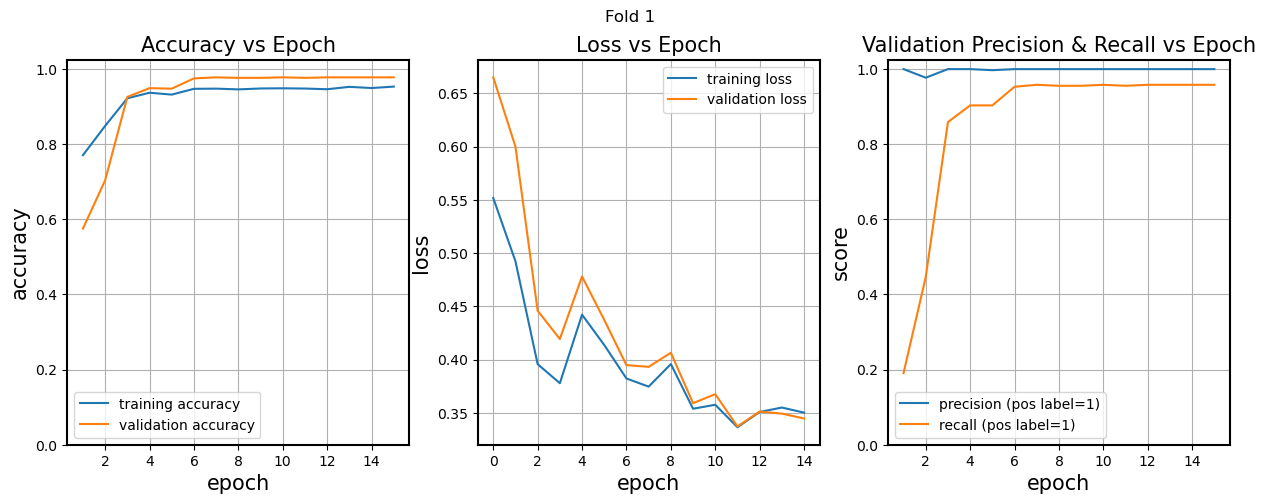

Fold 1 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 52.466% (383 / 730); Unique module_ids: [1, 254]
Percent cloudy (in train) = 56.118% (2472 / 4405); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


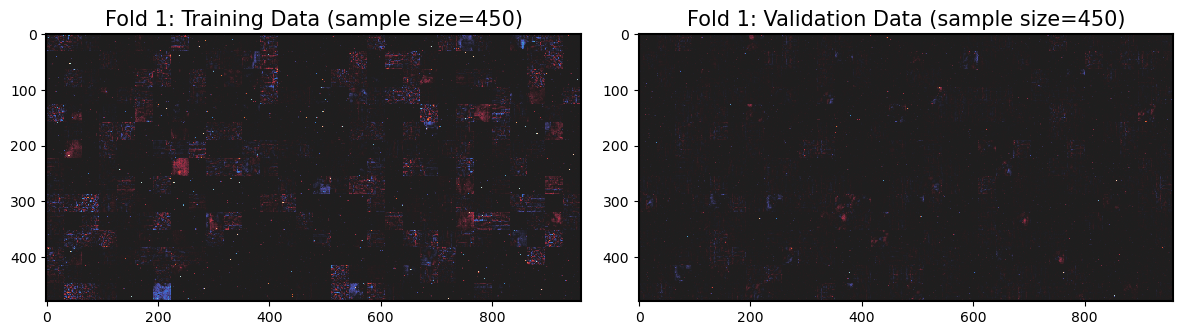

Doing Fold 2 of 8


Epoch 1


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.8095,  acc = 373/730 (51.10%) 
      Train: 	loss = 0.4810,  acc = 2957/3675 (80.46%)


Epoch 2


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.7280,  acc = 375/730 (51.37%) 
      Train: 	loss = 0.4162,  acc = 3324/3675 (90.45%)


Epoch 3


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.7271,  acc = 375/730 (51.37%) 
      Train: 	loss = 0.3921,  acc = 3373/3675 (91.78%)


Epoch 4


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6794,  acc = 375/730 (51.37%) 
      Train: 	loss = 0.4158,  acc = 3490/3675 (94.97%)


Epoch 5


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6963,  acc = 374/730 (51.23%) 
      Train: 	loss = 0.3806,  acc = 3497/3675 (95.16%)


Epoch 6


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6794,  acc = 380/730 (52.05%) 
      Train: 	loss = 0.3533,  acc = 3505/3675 (95.37%)


Epoch 7


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6500,  acc = 442/730 (60.55%) 
      Train: 	loss = 0.3573,  acc = 3543/3675 (96.41%)


Epoch 8


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6814,  acc = 401/730 (54.93%) 
      Train: 	loss = 0.3947,  acc = 3522/3675 (95.84%)


Epoch 9


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6897,  acc = 393/730 (53.84%) 
      Train: 	loss = 0.3781,  acc = 3507/3675 (95.43%)


Epoch 10


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6459,  acc = 442/730 (60.55%) 
      Train: 	loss = 0.3484,  acc = 3542/3675 (96.38%)


Epoch 11


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6591,  acc = 445/730 (60.96%) 
      Train: 	loss = 0.3345,  acc = 3536/3675 (96.22%)


Epoch 12


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6534,  acc = 436/730 (59.73%) 
      Train: 	loss = 0.3475,  acc = 3527/3675 (95.97%)


Epoch 13


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6443,  acc = 464/730 (63.56%) 
      Train: 	loss = 0.3443,  acc = 3548/3675 (96.54%)


Epoch 14


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6772,  acc = 420/730 (57.53%) 
      Train: 	loss = 0.3578,  acc = 3527/3675 (95.97%)


Epoch 15


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6363,  acc = 457/730 (62.60%) 
      Train: 	loss = 0.3495,  acc = 3540/3675 (96.33%)
Done training
2


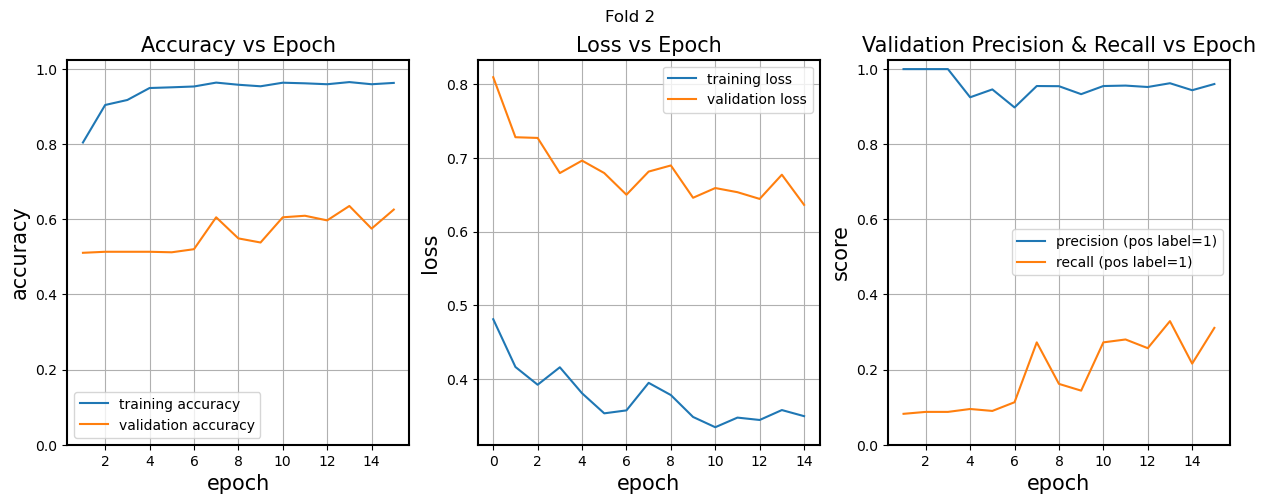

Fold 2 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.288% (389 / 730); Unique module_ids: [1, 254]
Percent cloudy (in train) = 55.864% (2053 / 3675); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


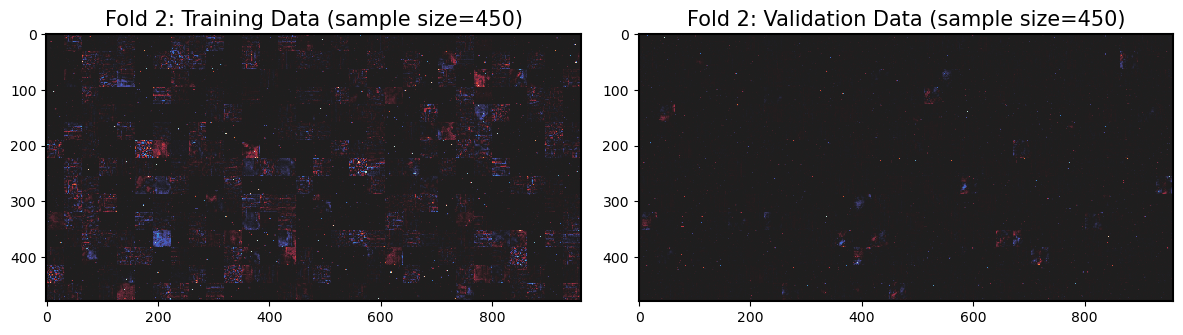

Doing Fold 3 of 8


Epoch 1


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.7509,  acc = 327/730 (44.79%) 
      Train: 	loss = 0.6015,  acc = 2554/3675 (69.50%)


Epoch 2


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6586,  acc = 405/730 (55.48%) 
      Train: 	loss = 0.4902,  acc = 3159/3675 (85.96%)


Epoch 3


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6753,  acc = 387/730 (53.01%) 
      Train: 	loss = 0.4542,  acc = 3252/3675 (88.49%)


Epoch 4


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5713,  acc = 547/730 (74.93%) 
      Train: 	loss = 0.3865,  acc = 3515/3675 (95.65%)


Epoch 5


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5499,  acc = 555/730 (76.03%) 
      Train: 	loss = 0.3530,  acc = 3507/3675 (95.43%)


Epoch 6


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5335,  acc = 568/730 (77.81%) 
      Train: 	loss = 0.3458,  acc = 3517/3675 (95.70%)


Epoch 7


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4761,  acc = 597/730 (81.78%) 
      Train: 	loss = 0.3186,  acc = 3545/3675 (96.46%)


Epoch 8


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5254,  acc = 577/730 (79.04%) 
      Train: 	loss = 0.3578,  acc = 3530/3675 (96.05%)


Epoch 9


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4810,  acc = 600/730 (82.19%) 
      Train: 	loss = 0.3344,  acc = 3549/3675 (96.57%)


Epoch 10


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4862,  acc = 593/730 (81.23%) 
      Train: 	loss = 0.3274,  acc = 3542/3675 (96.38%)


Epoch 11


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5128,  acc = 579/730 (79.32%) 
      Train: 	loss = 0.3448,  acc = 3538/3675 (96.27%)


Epoch 12


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4857,  acc = 601/730 (82.33%) 
      Train: 	loss = 0.3433,  acc = 3551/3675 (96.63%)


Epoch 13


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4424,  acc = 616/730 (84.38%) 
      Train: 	loss = 0.3292,  acc = 3568/3675 (97.09%)


Epoch 14


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4659,  acc = 606/730 (83.01%) 
      Train: 	loss = 0.3316,  acc = 3554/3675 (96.71%)


Epoch 15


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4793,  acc = 606/730 (83.01%) 
      Train: 	loss = 0.3405,  acc = 3554/3675 (96.71%)
Done training
3


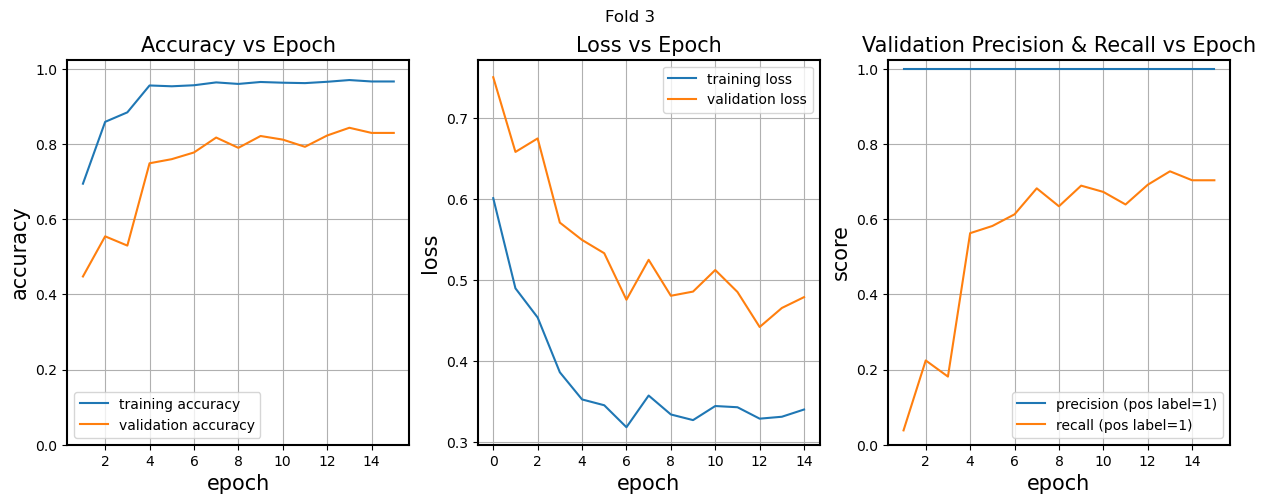

Fold 3 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 57.397% (419 / 730); Unique module_ids: [1, 254]
Percent cloudy (in train) = 55.565% (2042 / 3675); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


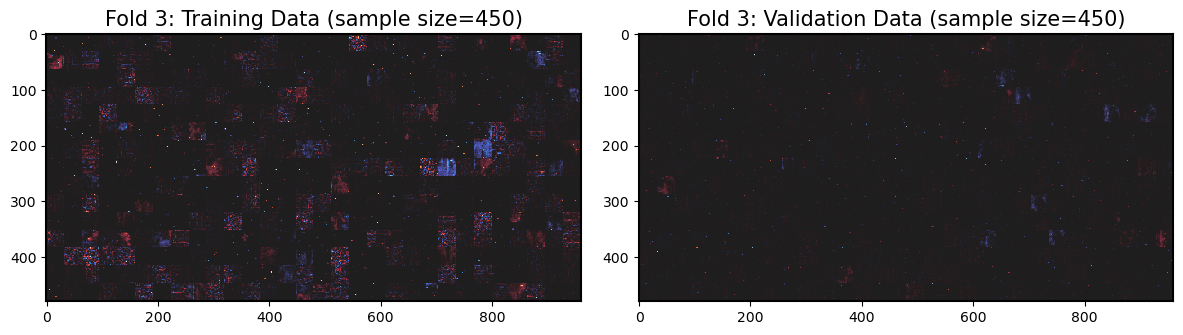

Doing Fold 4 of 8


Epoch 1


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5956,  acc = 629/730 (86.16%) 
      Train: 	loss = 0.6460,  acc = 2496/3675 (67.92%)


Epoch 2


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5313,  acc = 498/730 (68.22%) 
      Train: 	loss = 0.5739,  acc = 2703/3675 (73.55%)


Epoch 3


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4544,  acc = 682/730 (93.42%) 
      Train: 	loss = 0.5042,  acc = 3266/3675 (88.87%)


Epoch 4


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4423,  acc = 689/730 (94.38%) 
      Train: 	loss = 0.4829,  acc = 3318/3675 (90.29%)


Epoch 5


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4090,  acc = 689/730 (94.38%) 
      Train: 	loss = 0.4504,  acc = 3333/3675 (90.69%)


Epoch 6


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4008,  acc = 703/730 (96.30%) 
      Train: 	loss = 0.4262,  acc = 3439/3675 (93.58%)


Epoch 7


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4013,  acc = 704/730 (96.44%) 
      Train: 	loss = 0.4250,  acc = 3458/3675 (94.10%)


Epoch 8


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4130,  acc = 701/730 (96.03%) 
      Train: 	loss = 0.4395,  acc = 3415/3675 (92.93%)


Epoch 9


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3988,  acc = 713/730 (97.67%) 
      Train: 	loss = 0.4183,  acc = 3521/3675 (95.81%)


Epoch 10


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3795,  acc = 703/730 (96.30%) 
      Train: 	loss = 0.4132,  acc = 3436/3675 (93.50%)


Epoch 11


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3842,  acc = 713/730 (97.67%) 
      Train: 	loss = 0.4066,  acc = 3529/3675 (96.03%)


Epoch 12


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3781,  acc = 709/730 (97.12%) 
      Train: 	loss = 0.4045,  acc = 3511/3675 (95.54%)


Epoch 13


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3698,  acc = 710/730 (97.26%) 
      Train: 	loss = 0.3947,  acc = 3519/3675 (95.76%)


Epoch 14


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3638,  acc = 703/730 (96.30%) 
      Train: 	loss = 0.3885,  acc = 3490/3675 (94.97%)


Epoch 15


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3614,  acc = 705/730 (96.58%) 
      Train: 	loss = 0.3880,  acc = 3493/3675 (95.05%)
Done training
4


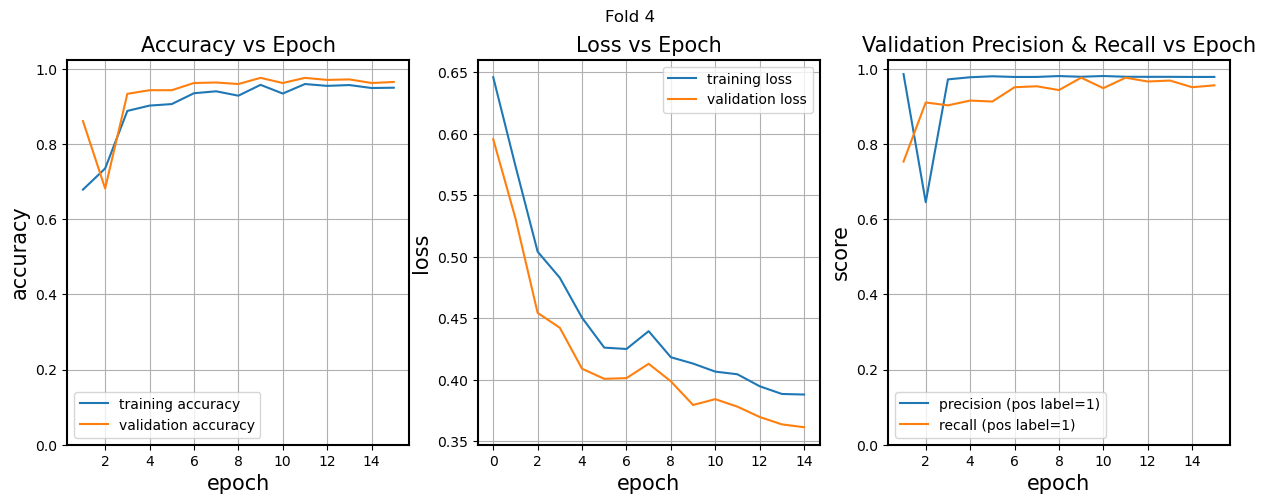

Fold 4 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.973% (394 / 730); Unique module_ids: [1, 254]
Percent cloudy (in train) = 53.388% (1962 / 3675); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


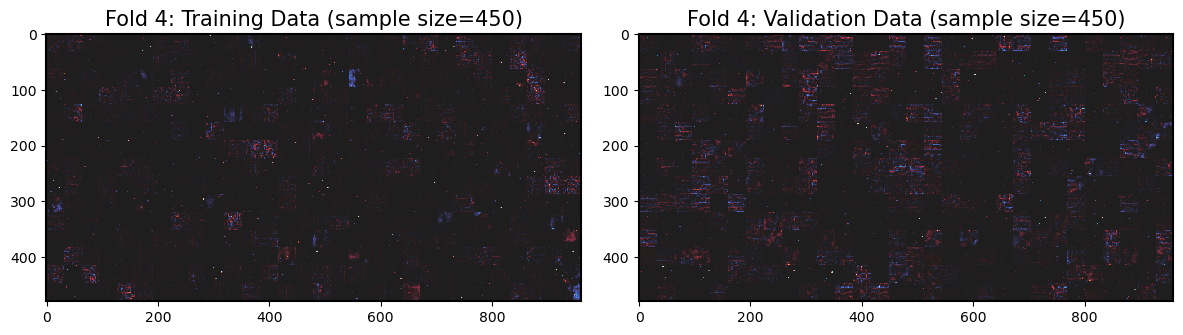

Doing Fold 5 of 8


Epoch 1


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5608,  acc = 674/730 (92.33%) 
      Train: 	loss = 0.6563,  acc = 2736/3675 (74.45%)


Epoch 2


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4151,  acc = 686/730 (93.97%) 
      Train: 	loss = 0.5850,  acc = 3105/3675 (84.49%)


Epoch 3


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4322,  acc = 673/730 (92.19%) 
      Train: 	loss = 0.5754,  acc = 3127/3675 (85.09%)


Epoch 4


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3926,  acc = 697/730 (95.48%) 
      Train: 	loss = 0.5108,  acc = 3453/3675 (93.96%)


Epoch 5


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3505,  acc = 705/730 (96.58%) 
      Train: 	loss = 0.4725,  acc = 3420/3675 (93.06%)


Epoch 6


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3696,  acc = 705/730 (96.58%) 
      Train: 	loss = 0.4802,  acc = 3437/3675 (93.52%)


Epoch 7


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3344,  acc = 701/730 (96.03%) 
      Train: 	loss = 0.4260,  acc = 3489/3675 (94.94%)


Epoch 8


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3381,  acc = 705/730 (96.58%) 
      Train: 	loss = 0.4244,  acc = 3465/3675 (94.29%)


Epoch 9


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3208,  acc = 704/730 (96.44%) 
      Train: 	loss = 0.4023,  acc = 3472/3675 (94.48%)


Epoch 10


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3258,  acc = 701/730 (96.03%) 
      Train: 	loss = 0.3867,  acc = 3497/3675 (95.16%)


Epoch 11


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3231,  acc = 703/730 (96.30%) 
      Train: 	loss = 0.3851,  acc = 3498/3675 (95.18%)


Epoch 12


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3316,  acc = 705/730 (96.58%) 
      Train: 	loss = 0.4006,  acc = 3495/3675 (95.10%)


Epoch 13


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3204,  acc = 703/730 (96.30%) 
      Train: 	loss = 0.3941,  acc = 3492/3675 (95.02%)


Epoch 14


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3443,  acc = 702/730 (96.16%) 
      Train: 	loss = 0.4029,  acc = 3500/3675 (95.24%)


Epoch 15


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3504,  acc = 704/730 (96.44%) 
      Train: 	loss = 0.4078,  acc = 3484/3675 (94.80%)
Done training
5


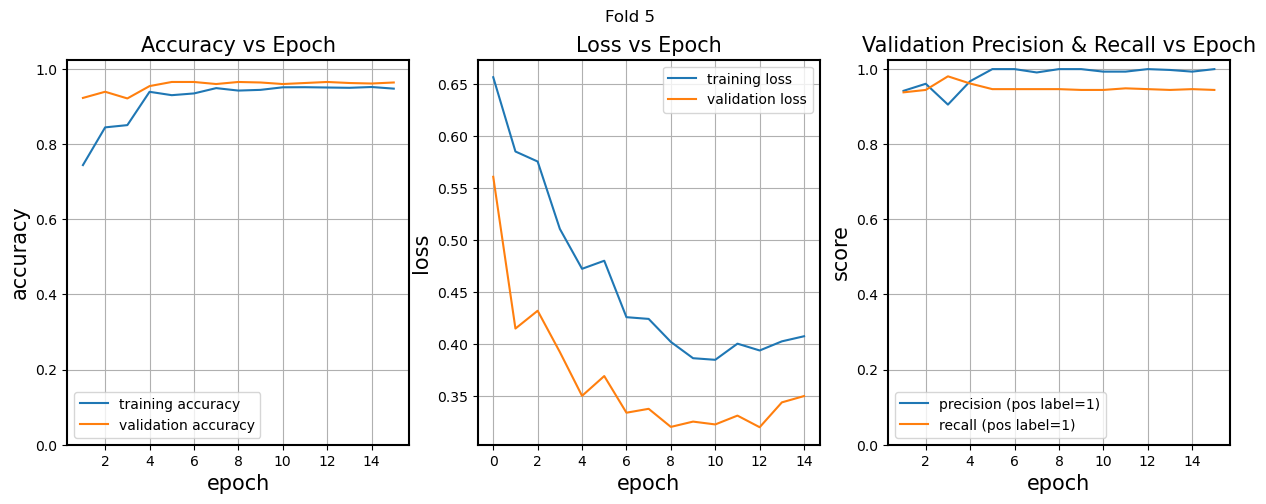

Fold 5 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 64.247% (469 / 730); Unique module_ids: [1, 254]
Percent cloudy (in train) = 54.259% (1994 / 3675); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


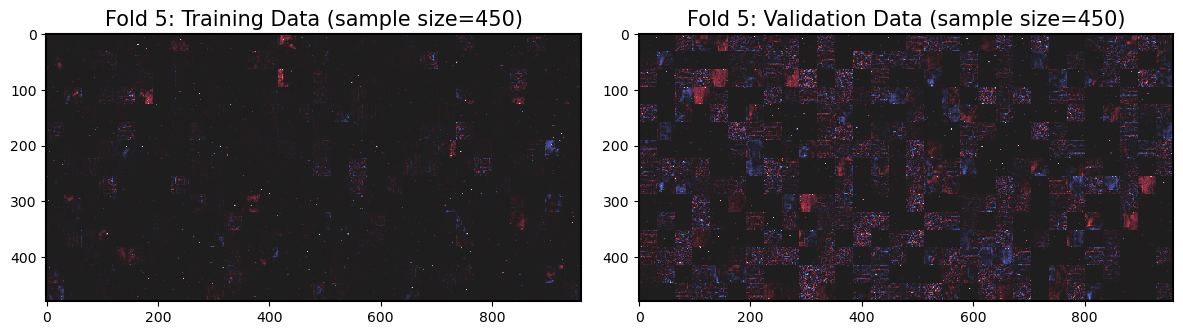

Doing Fold 6 of 8


Epoch 1


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5676,  acc = 443/730 (60.68%) 
      Train: 	loss = 0.6514,  acc = 2415/3675 (65.71%)


Epoch 2


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4496,  acc = 678/730 (92.88%) 
      Train: 	loss = 0.5755,  acc = 3047/3675 (82.91%)


Epoch 3


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4238,  acc = 701/730 (96.03%) 
      Train: 	loss = 0.5414,  acc = 3217/3675 (87.54%)


Epoch 4


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3826,  acc = 709/730 (97.12%) 
      Train: 	loss = 0.4754,  acc = 3272/3675 (89.03%)


Epoch 5


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3611,  acc = 708/730 (96.99%) 
      Train: 	loss = 0.4515,  acc = 3310/3675 (90.07%)


Epoch 6


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3489,  acc = 707/730 (96.85%) 
      Train: 	loss = 0.4392,  acc = 3292/3675 (89.58%)


Epoch 7


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3568,  acc = 709/730 (97.12%) 
      Train: 	loss = 0.4355,  acc = 3336/3675 (90.78%)


Epoch 8


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3337,  acc = 706/730 (96.71%) 
      Train: 	loss = 0.4082,  acc = 3375/3675 (91.84%)


Epoch 9


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3582,  acc = 708/730 (96.99%) 
      Train: 	loss = 0.4131,  acc = 3429/3675 (93.31%)


Epoch 10


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3544,  acc = 708/730 (96.99%) 
      Train: 	loss = 0.4077,  acc = 3452/3675 (93.93%)


Epoch 11


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3321,  acc = 707/730 (96.85%) 
      Train: 	loss = 0.4011,  acc = 3389/3675 (92.22%)


Epoch 12


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3472,  acc = 709/730 (97.12%) 
      Train: 	loss = 0.4086,  acc = 3455/3675 (94.01%)


Epoch 13


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3524,  acc = 708/730 (96.99%) 
      Train: 	loss = 0.4052,  acc = 3448/3675 (93.82%)


Epoch 14


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3226,  acc = 711/730 (97.40%) 
      Train: 	loss = 0.3761,  acc = 3463/3675 (94.23%)


Epoch 15


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3256,  acc = 711/730 (97.40%) 
      Train: 	loss = 0.3725,  acc = 3474/3675 (94.53%)
Done training
6


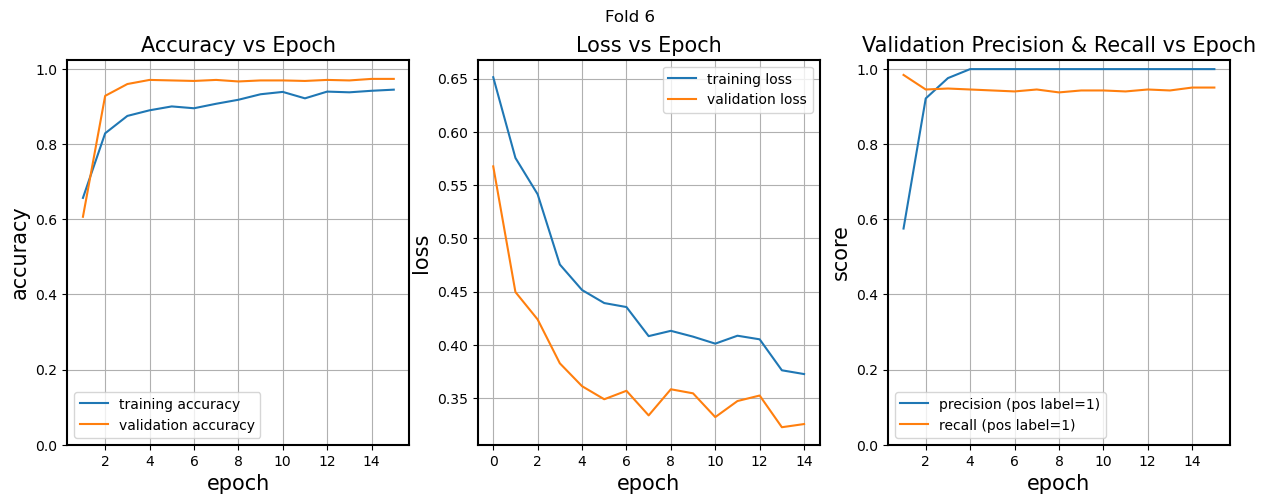

Fold 6 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.014% (387 / 730); Unique module_ids: [1, 254]
Percent cloudy (in train) = 54.803% (2014 / 3675); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


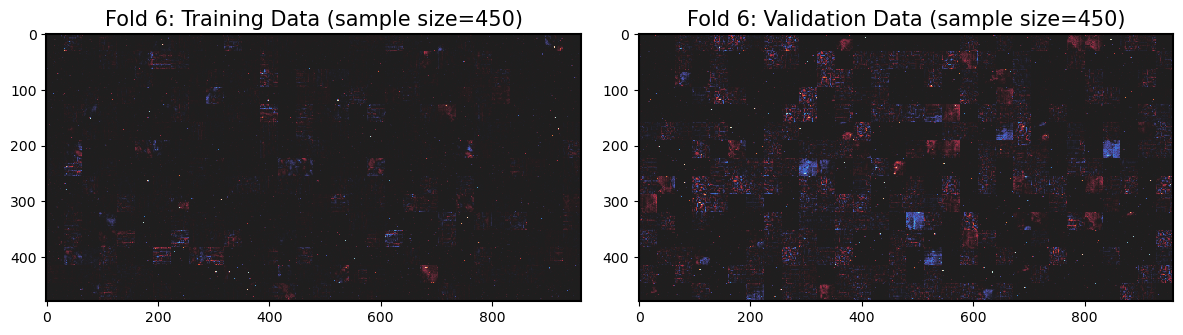

Doing Fold 7 of 8


Epoch 1


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.6074,  acc = 600/730 (82.19%) 
      Train: 	loss = 0.6180,  acc = 2559/3675 (69.63%)


Epoch 2


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.5369,  acc = 588/730 (80.55%) 
      Train: 	loss = 0.5533,  acc = 3168/3675 (86.20%)


Epoch 3


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4739,  acc = 673/730 (92.19%) 
      Train: 	loss = 0.5088,  acc = 3168/3675 (86.20%)


Epoch 4


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4120,  acc = 710/730 (97.26%) 
      Train: 	loss = 0.4538,  acc = 3364/3675 (91.54%)


Epoch 5


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.4098,  acc = 716/730 (98.08%) 
      Train: 	loss = 0.4536,  acc = 3392/3675 (92.30%)


Epoch 6


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3884,  acc = 715/730 (97.95%) 
      Train: 	loss = 0.4230,  acc = 3460/3675 (94.15%)


Epoch 7


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3483,  acc = 716/730 (98.08%) 
      Train: 	loss = 0.3957,  acc = 3417/3675 (92.98%)


Epoch 8


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3705,  acc = 717/730 (98.22%) 
      Train: 	loss = 0.4143,  acc = 3448/3675 (93.82%)


Epoch 9


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3784,  acc = 716/730 (98.08%) 
      Train: 	loss = 0.4101,  acc = 3499/3675 (95.21%)


Epoch 10


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3520,  acc = 716/730 (98.08%) 
      Train: 	loss = 0.3894,  acc = 3507/3675 (95.43%)


Epoch 11


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3716,  acc = 716/730 (98.08%) 
      Train: 	loss = 0.4104,  acc = 3481/3675 (94.72%)


Epoch 12


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3232,  acc = 715/730 (97.95%) 
      Train: 	loss = 0.3662,  acc = 3500/3675 (95.24%)


Epoch 13


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3522,  acc = 715/730 (97.95%) 
      Train: 	loss = 0.3989,  acc = 3434/3675 (93.44%)


Epoch 14


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3419,  acc = 715/730 (97.95%) 
      Train: 	loss = 0.3820,  acc = 3505/3675 (95.37%)


Epoch 15


  0%|          | 0/58 [00:00<?, ?batches/s]

       Val: 	loss = 0.3490,  acc = 718/730 (98.36%) 
      Train: 	loss = 0.3831,  acc = 3511/3675 (95.54%)
Done training
7


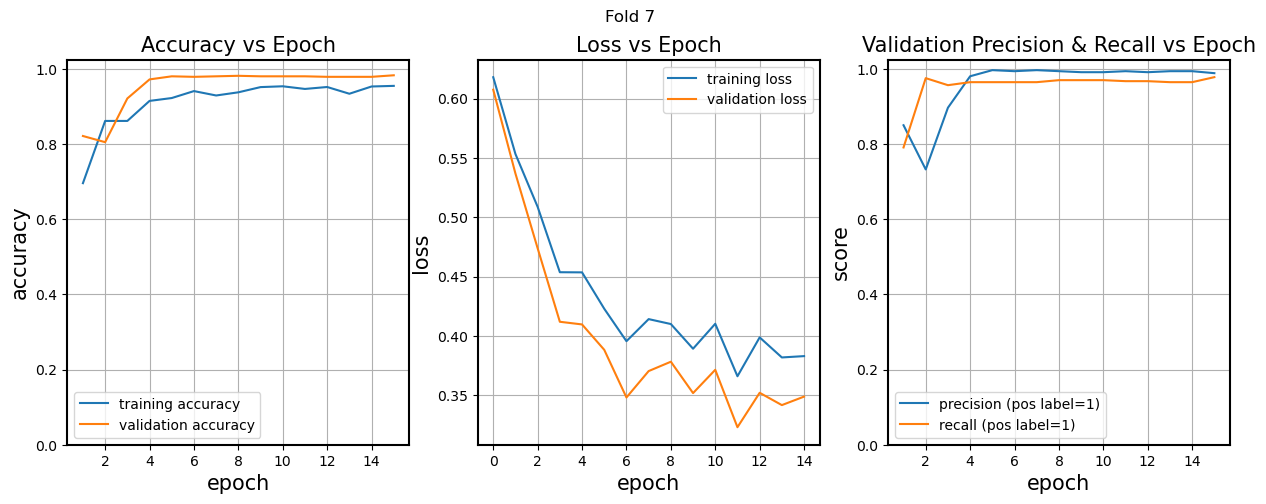

Fold 7 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 51.233% (374 / 730); Unique module_ids: [1, 254]
Percent cloudy (in train) = 56.109% (2062 / 3675); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


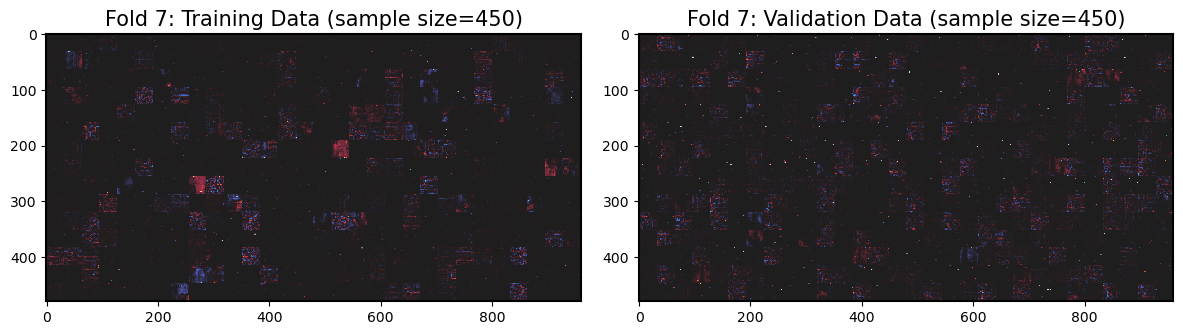

Doing Fold 8 of 8


Epoch 1


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.6380,  acc = 625/730 (85.62%) 
      Train: 	loss = 0.6220,  acc = 3263/4380 (74.50%)


Epoch 2


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.5608,  acc = 495/730 (67.81%) 
      Train: 	loss = 0.5696,  acc = 2502/4380 (57.12%)


Epoch 3


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4918,  acc = 696/730 (95.34%) 
      Train: 	loss = 0.5159,  acc = 3799/4380 (86.74%)


Epoch 4


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4303,  acc = 694/730 (95.07%) 
      Train: 	loss = 0.4689,  acc = 3844/4380 (87.76%)


Epoch 5


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3941,  acc = 692/730 (94.79%) 
      Train: 	loss = 0.4192,  acc = 4081/4380 (93.17%)


Epoch 6


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4190,  acc = 688/730 (94.25%) 
      Train: 	loss = 0.4420,  acc = 4061/4380 (92.72%)


Epoch 7


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4240,  acc = 693/730 (94.93%) 
      Train: 	loss = 0.4398,  acc = 4167/4380 (95.14%)


Epoch 8


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4059,  acc = 691/730 (94.66%) 
      Train: 	loss = 0.4211,  acc = 4106/4380 (93.74%)


Epoch 9


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4049,  acc = 691/730 (94.66%) 
      Train: 	loss = 0.4214,  acc = 4144/4380 (94.61%)


Epoch 10


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4167,  acc = 694/730 (95.07%) 
      Train: 	loss = 0.4375,  acc = 4103/4380 (93.68%)


Epoch 11


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4005,  acc = 692/730 (94.79%) 
      Train: 	loss = 0.4209,  acc = 4093/4380 (93.45%)


Epoch 12


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.4118,  acc = 690/730 (94.52%) 
      Train: 	loss = 0.4153,  acc = 4191/4380 (95.68%)


Epoch 13


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3717,  acc = 696/730 (95.34%) 
      Train: 	loss = 0.3898,  acc = 4190/4380 (95.66%)


Epoch 14


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3783,  acc = 692/730 (94.79%) 
      Train: 	loss = 0.3917,  acc = 4151/4380 (94.77%)


Epoch 15


  0%|          | 0/69 [00:00<?, ?batches/s]

       Val: 	loss = 0.3646,  acc = 694/730 (95.07%) 
      Train: 	loss = 0.3772,  acc = 4151/4380 (94.77%)
Done training
8


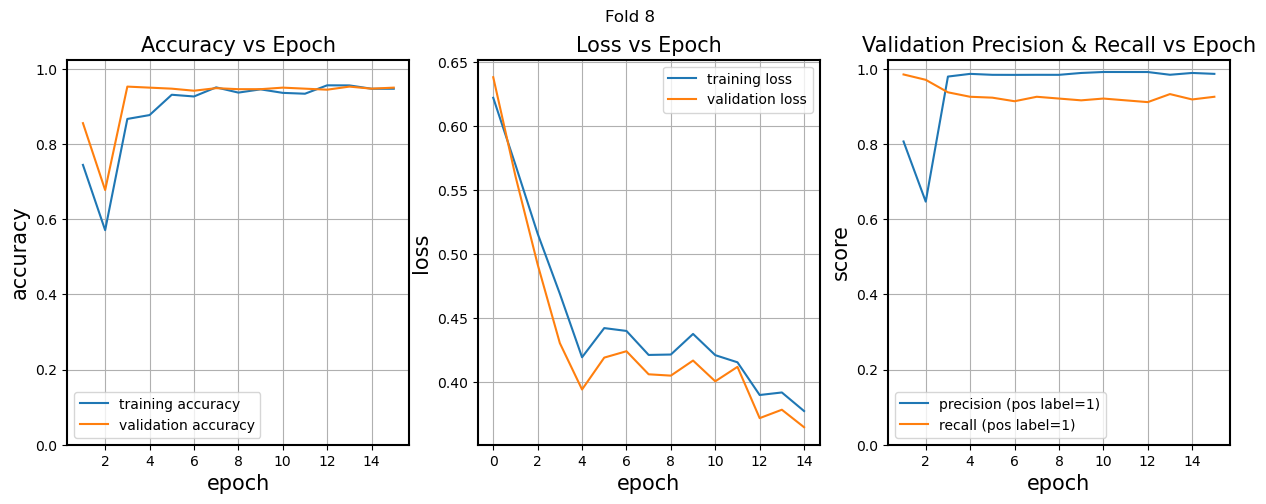

Fold 8 Class Stats
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 57.671% (421 / 730); Unique module_ids: [1, 254]
Percent cloudy (in train) = 55.731% (2441 / 4380); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]


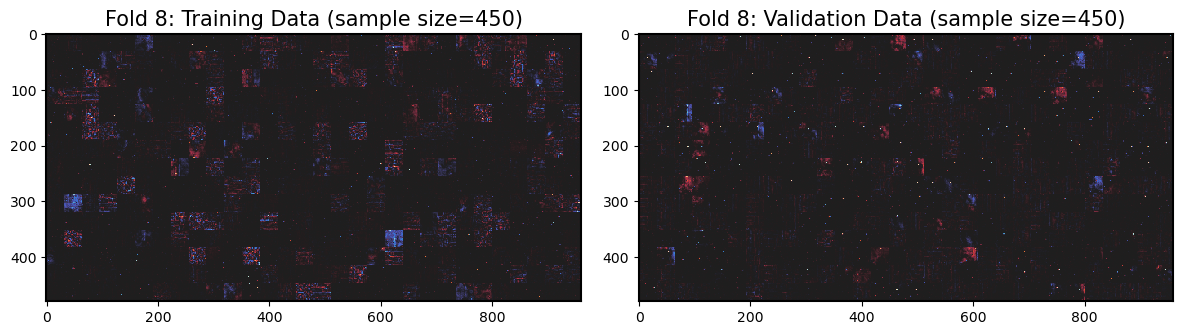

Average validation accuracy: 0.9056506849315069


In [20]:
validation_accuracies, trainers = do_cross_validation(test_prop, nfolds)

  0%|          | 0/46 [00:00<?, ?batches/s]

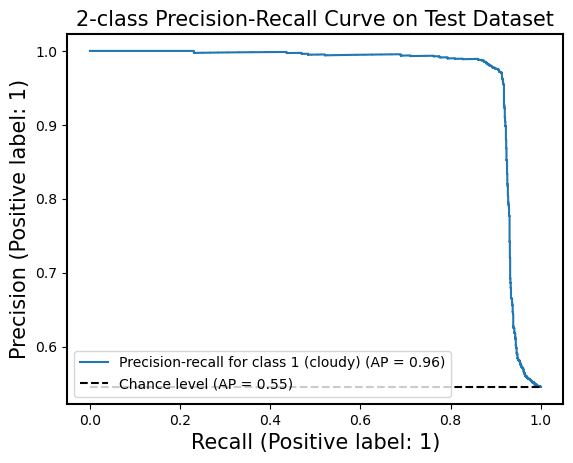

Test: 	loss = 0.3904,  acc = 2816/2934 (95.98%)


In [21]:
test_model = CloudDetection()
test_model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth'))
loss_fn = nn.CrossEntropyLoss()
tester = Tester(test_model, loss_fn, test_loader)
tester.eval()

In [24]:
# Training config
learning_rate = 0.001
weight_decay = 1e-5
epochs = 20
gamma = 0.9
# momentum=0.9

model = CloudDetection()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()


trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=epochs, gamma=gamma, do_summary=True,
    # img_type=img_type
);
gc.collect();


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          640
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 64, 32, 32]          128
|    └─Dropout2d: 2-4                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-6                         [-1, 64, 32, 32]          --
|    └─BatchNorm2d: 2-7                  [-1, 64, 32, 32]          128
|    └─Dropout2d: 2-8                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-9                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-10                        [-1, 64, 32, 32]          --
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─MaxPool2d: 2-12                   [-1, 64, 10, 10]          --
|  

In [ ]:
trainer.train(make_train_logs=False)

In [ ]:
tester = Tester(model, loss_fn, test_loader)
tester.eval()